# Primerjava pristopov za luščenje ključnih besed na anotiranih besedilih iz revije Prispevki za novejšo zgodovino

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz  besedil iz revije Prispevki za novejšo zgodovino, ki imajo označene ključne besede. Ključne besede so označene s strani avtorjev člankov.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede s ključnimi besedami, ki so jih označili avtorji člankov. V primerjavi z zvezkom `04_06_specific_words_comparison_ctch` bomo v tem zvezku uporabili drugačno mero za vrednotenje, ki temelji na računanju povprečne maksimalne podobnosti med ključnimi besedami predlaganimi s strani avtorja in s strani metode za odkrivanje ključnih besed.

In [1]:
import string
import ast

import nltk
from textsemantics.server_api import ServerAPI
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from matplotlib import pyplot as plt
import yake
from gensim.summarization import keywords as gensim_kw
import rake

from textsemantics import specific_words
from utils.scores import score_in_len_range, average_max_similarity

Naložimo metapodatke in dokumente iz zbirke CTCH - članki objavljeni v reviji CPrispevki za novejšo zgodovino. Dokumente preprocesiramo in izluščimo posamezne besede.

In [2]:
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('CTCH')
metadata["texts"] = api.get_texts(urls=metadata['File'])
# stolpec s ključnimi besedami vsebuje seznam zapisan kot niz - pretovri v seznam
metadata["Keywords"] = metadata["Keywords"].apply(ast.literal_eval)
# pretvorba ključnih besed v posamezne besede in lematizacija
metadata["Keywords_one_word"] = metadata["Keywords"].apply(
    lambda ph: [lemmatizer.lemmatize(w) for p in ph for w in p.split()]
)
# izpusti en članek brez ključnih besed
metadata = metadata[metadata["Keywords_one_word"].str.len() != 0]

full_texts = metadata["Abstract"] + "\n" + metadata["texts"]
tokens_list = preprocess(full_texts)

print(f"Število dokumentov: {len(metadata)}")

Število dokumentov: 83


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [3]:
metadata.head()

,Title,Abstract,Keywords,File,URL,texts,Keywords_one_word
0,Hrana na bojiščih prve svetovne vojne: izkušnj...,Prehrana vojakov na bojišču je bila vedno izre...,"[Avstro-Ogrska, 1. svetovna vojna, vojaška izk...",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/95/109,1. Raziskovanje vojaških izkušenj\nV zadnjih d...,"[Avstro-Ogrski, 1., svetoven, vojen, vojaški, ..."
1,Ženske v vojni in o véliki vojni,Članek se ukvarja z vplivi prve svetovne vojne...,"[prva svetovna vojna, ženske, zgodovina spola,...",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/91/113,V zadnjih dvajsetih letih je prva svetovna voj...,"[prvi, svetoven, vojen, ženski, zgodovina, spo..."
2,»Militarizacija materinstva« – ženski »naravni...,"Prispevek s pomočjo publicistike, zakonodaje, ...","[materinstvo, rodnost, vzgoja, otroci, ženske]",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/92/114,1. Uvod1\nV času prve svetovne vojne je v štev...,"[materinstvo, rodnost, vzgoja, otrok, ženski]"
3,Skrb v službi vojne: bolniške strežnice na Kra...,Že pred začetkom prve svetovne vojne je v Avst...,"[bolniške sestre, strežnice, prva svetovna voj...",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/84/111,1. Uvod\nNa Slovenskem dojemanje prve svetovne...,"[bolniški, sestra, strežnica, prvi, svetoven, ..."
4,K razumevanju ženskega dela v veliki vojni1,Članek se ukvarja s presekom vojne ekonomije i...,"[prva svetovna vojna, vojno gospodarstvo, žens...",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/90/106,1. Uvod\nIzstopajoči delež zgodovinskih razisk...,"[prvi, svetoven, vojen, vojen, gospodarstvo, ž..."


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metodi z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) 1) upoštevajoč vse besede v korpusu, 2) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [4]:
%%time 
tfidf_keywords = specific_words.tfidf_keywords(tokens=tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

CPU times: user 3.91 s, sys: 26.4 ms, total: 3.93 s
Wall time: 3.94 s


In [5]:
%%time
emb_corp_keywords = specific_words.embedding_corpus_keywords(tokens=tokens_list)
emb_corp_keywords = [[x for x, _ in wds] for wds in emb_corp_keywords]

CPU times: user 1min 24s, sys: 1.03 s, total: 1min 25s
Wall time: 1min 25s


In [6]:
%%time 
emb_doc_keywords = specific_words.embedding_document_keywords(tokens=tokens_list)
emb_doc_keywords = [[x for x, _ in wds] for wds in emb_doc_keywords]

CPU times: user 19 s, sys: 580 ms, total: 19.6 s
Wall time: 19.7 s


In [7]:
%%time 
stop_path = "utils/slovenian-stopwords.txt"
def rake_method(text):
    rake_object = rake.Rake(stop_path, max_words_length=1)
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [lemmatizer.lemmatize(x) for x, _ in kw]

rake_keywords = [rake_method(txt) for txt in full_texts]

CPU times: user 45.2 s, sys: 9.24 ms, total: 45.2 s
Wall time: 45.3 s


In [8]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="sl", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [lemmatizer.lemmatize(x) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in full_texts]

CPU times: user 44.9 s, sys: 717 ms, total: 45.7 s
Wall time: 45.8 s


In [9]:
%%time
def text_rank(tokens):
    kw = gensim_kw(" ".join(tokens), words=20, scores=True)
    return [x for w, _ in kw for x in w.split()]

text_rank_keywords = [text_rank(tokens) for tokens in tokens_list]

CPU times: user 4min 23s, sys: 39.8 s, total: 5min 3s
Wall time: 4min 46s


In [10]:
methods = [
    ("Emb - korpus", emb_corp_keywords),
    ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [11]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

Emb - korpus - Povprečno število besed: 25670.0 Minimalno število specifičnih besed: 25670
Emb - document - Povprečno število besed: 1354.6 Minimalno število specifičnih besed: 707
TFIDF - Povprečno število besed: 1354.4 Minimalno število specifičnih besed: 707
RAKE - Povprečno število besed: 577.0 Minimalno število specifičnih besed: 96
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 20
TextRank - Povprečno število besed: 20.4 Minimalno število specifičnih besed: 20


Izračunajmo natančnost s pripravljeno meramo in jo izrišimo. Izračunamo povprečno maksimalno podobnost za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo mero za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. 


In [12]:
kw = metadata['Keywords_one_word']
sim_scores = [score_in_len_range(pred, kw, average_max_similarity, embeddings=True) for _, pred in methods]

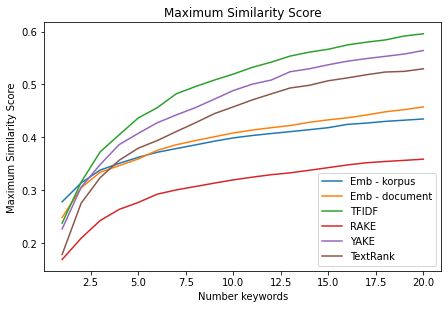

In [13]:
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Maximum Similarity Score", sim_scores),
)
for i, (title, sc) in enumerate(scores):
    plt.subplot(2, 2, i + 1)
    for p, (l, _) in zip(sc, methods):
        plt.plot(range(1, 21), p, label=l)
    plt.legend()
    plt.title(title)
    plt.xlabel("Number keywords")
    plt.ylabel(title)
        
plt.tight_layout()

Opazimo lahko zelo podobne rezultate kot pri primerjavi z uporabo preciznosti, preklica in mere F1.